In [51]:
!pip install nltk scikit-learn pandas matplotlib

In [52]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
import os
import re
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
DATA_PATH = "/content/drive/MyDrive/Ranjitha-DS-Project/combined_dataset_New.csv"

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (8577, 4)


,title,source,category,content
0,Neural network (machine learning),Wikipedia,Machine learning,"In machine learning, a neural network or neura..."
1,15.ai,Wikipedia,Machine learning,15.ai is a free non-commercial web application...
2,3Blue1Brown,Wikipedia,Machine learning,3Blue1Brown is an educational YouTube channel ...
3,3D reconstruction,Wikipedia,Machine learning,"In computer vision and computer graphics, 3D r..."
4,AAAI Conference on Artificial Intelligence,Wikipedia,Machine learning,The AAAI Conference on Artificial Intelligence...


**Basic cleaning and keep only useful rows:**

This cell keeps only rows that have text, removes exact duplicate texts,
and shows some simple information about the dataset.

In [56]:
TEXT_COL = "content"
# Keep only rows where text is not null
df = df[df[TEXT_COL].notna()].copy()

# Remove duplicate texts if any
df = df.drop_duplicates(subset=[TEXT_COL]).reset_index(drop=True)

print("After cleaning empty/duplicate texts:", df.shape)
print(df.columns)


After cleaning empty/duplicate texts: (6534, 4)
Index(['title', 'source', 'category', 'content'], dtype='object')


**This cell defines helper functions:**

**clean_text** for basic text cleaning (lowercase, remove numbers, punctuation, stopwords)

**apply_stemmer** to apply Porter, Lancaster or Snowball stemmer.

In [57]:
stop_words = set(stopwords.words("english"))

ps = PorterStemmer()
ls = LancasterStemmer()
ss = SnowballStemmer("english")

def clean_text(text: str) -> str:
    """Basic text cleaning: lowercase, remove digits, punctuation, stopwords."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # remove digits
    text = re.sub(r"\d+", " ", text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # tokenise on whitespace
    tokens = text.split()
    # remove stopwords
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)


def apply_stemmer(text: str, algo: str) -> str:
    """Apply the chosen stemmer to a cleaned text string."""
    if not isinstance(text, str):
        return ""
    tokens = text.split()
    if algo == "porter":
        stemmer = ps
    elif algo == "lancaster":
        stemmer = ls
    elif algo == "snowball":
        stemmer = ss
    else:
        raise ValueError("Unknown stemmer name")
    return " ".join(stemmer.stem(t) for t in tokens)


**This cell creates new columns:**

content_clean: cleaned text

content_porter: cleaned + Porter stemmer

content_lancaster: cleaned + Lancaster stemmer

content_snowball: cleaned + Snowball stemmer

In [58]:
df["content_clean"] = df[TEXT_COL].astype(str).map(clean_text)

df["content_porter"] = df["content_clean"].map(lambda t: apply_stemmer(t, "porter"))
df["content_lancaster"] = df["content_clean"].map(lambda t: apply_stemmer(t, "lancaster"))
df["content_snowball"] = df["content_clean"].map(lambda t: apply_stemmer(t, "snowball"))

df[["content_clean", "content_porter", "content_lancaster", "content_snowball"]].head()

,content_clean,content_porter,content_lancaster,content_snowball
0,machine learning neural network neural net nn ...,machin learn neural network neural net nn also...,machin learn neur network neur net nn also cal...,machin learn neural network neural net nn also...
1,ai free noncommercial web application research...,ai free noncommerci web applic research projec...,ai fre noncommerc web apply research project u...,ai free noncommerci web applic research projec...
2,blue brown educational youtube channel created...,blue brown educ youtub channel creat run grant...,blu brown educ youtub channel cre run grant sa...,blue brown educ youtub channel creat run grant...
3,computer vision computer graphics reconstructi...,comput vision comput graphic reconstruct proce...,comput vis comput graph reconstruct process ca...,comput vision comput graphic reconstruct proce...
4,aaai conference artificial intelligence aaai l...,aaai confer artifici intellig aaai lead intern...,aaa conf art intellig aaa lead intern academ c...,aaai confer artifici intellig aaai lead intern...


This cell prepares the ground truth labels for external evaluation (ARI).


In [59]:
if "category" in df.columns:
    print("Using existing 'category' column to create true_label.")

    # Clean category values
    df["category"] = df["category"].astype(str).str.strip().str.lower()

    # Map categories to clean labels
    mapping = {
        "politics": "politics",
        "bbc_politics": "politics",
        "sports": "sports",
        "bbc_sport": "sports",
        "technology": "technology",
        "bbc_technology": "technology",
        "machine_learning": "technology",
        "machine learning": "technology",
        "environment": "environment",
        "climate_change": "environment",
        "climate change": "environment",
        # add your own categories here
    }

    df["true_label"] = df["category"].map(mapping)
    print(df["true_label"].value_counts(dropna=False))

df.head()

Using existing 'category' column to create true_label.
true_label
sports         2151
environment    1767
politics       1312
technology     1036
NaN             268
Name: count, dtype: int64


,title,source,category,content,content_clean,content_porter,content_lancaster,content_snowball,true_label
0,Neural network (machine learning),Wikipedia,machine learning,"In machine learning, a neural network or neura...",machine learning neural network neural net nn ...,machin learn neural network neural net nn also...,machin learn neur network neur net nn also cal...,machin learn neural network neural net nn also...,technology
1,15.ai,Wikipedia,machine learning,15.ai is a free non-commercial web application...,ai free noncommercial web application research...,ai free noncommerci web applic research projec...,ai fre noncommerc web apply research project u...,ai free noncommerci web applic research projec...,technology
2,3Blue1Brown,Wikipedia,machine learning,3Blue1Brown is an educational YouTube channel ...,blue brown educational youtube channel created...,blue brown educ youtub channel creat run grant...,blu brown educ youtub channel cre run grant sa...,blue brown educ youtub channel creat run grant...,technology
3,3D reconstruction,Wikipedia,machine learning,"In computer vision and computer graphics, 3D r...",computer vision computer graphics reconstructi...,comput vision comput graphic reconstruct proce...,comput vis comput graph reconstruct process ca...,comput vision comput graphic reconstruct proce...,technology
4,AAAI Conference on Artificial Intelligence,Wikipedia,machine learning,The AAAI Conference on Artificial Intelligence...,aaai conference artificial intelligence aaai l...,aaai confer artifici intellig aaai lead intern...,aaa conf art intellig aaa lead intern academ c...,aaai confer artifici intellig aaai lead intern...,technology


**Create imbalanced and balanced versions of the dataset.**

This cell keeps the original (imbalanced) dataset,
and creates a balanced version by downsampling each class to the same size.
This is used to compare the effect of class imbalance.

In [60]:
df_imbalanced = df.copy()  # this keeps natural imbalance

df_balanced = None
if "true_label" in df.columns:
    # Use only rows that have a label
    labelled = df[df["true_label"].notna()].copy()
    class_counts = labelled["true_label"].value_counts()
    print("Original labelled class counts:")
    print(class_counts)

    # downsample each class to the size of the smallest class
    min_size = class_counts.min()
    print("\nMinimum size of category is : ")
    print(min_size)
    balanced_n = min(min_size, 700)   # cap at 700 per class

    df_balanced = (
        labelled.groupby("true_label", group_keys=False)
                .apply(lambda g: g.sample(balanced_n, random_state=42))
                .reset_index(drop=True)
    )
    print("\nBalanced labelled class counts:")
    print(df_balanced["true_label"].value_counts())

df_balanced.head() # this will show balance dataset

Original labelled class counts:
true_label
sports         2151
environment    1767
politics       1312
technology     1036
Name: count, dtype: int64

Minimum size of category is : 
1036

Balanced labelled class counts:
true_label
environment    700
politics       700
sports         700
technology     700
Name: count, dtype: int64


/tmp/ipython-input-3095685810.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(balanced_n, random_state=42))


,title,source,category,content,content_clean,content_porter,content_lancaster,content_snowball,true_label
0,Human population projections,Wikipedia,climate change,Human population projections are attempts to e...,human population projections attempts extrapol...,human popul project attempt extrapol human pop...,hum pop project attempt extrapol hum pop chang...,human popul project attempt extrapol human pop...,environment
1,Deforestation and climate change,Wikipedia,climate change,Deforestation is a primary contributor to clim...,deforestation primary contributor climate chan...,deforest primari contributor climat chang clim...,deforest prim contribut clim chang clim chang ...,deforest primari contributor climat chang clim...,environment
2,Leiden University,Wikipedia,climate change,Leiden University (abbreviated as LEI; Dutch: ...,leiden university abbreviated lei dutch univer...,leiden univers abbrevi lei dutch universiteit ...,leid univers abbrevy lei dutch universiteit le...,leiden univers abbrevi lei dutch universiteit ...,environment
3,Calcium,Wikipedia,climate change,Calcium is a chemical element; it has symbol C...,calcium chemical element symbol ca atomic numb...,calcium chemic element symbol ca atom number a...,calc chem el symbol ca atom numb alkalin ear m...,calcium chemic element symbol ca atom number a...,environment
4,Car,Wikipedia,climate change,"A car, or an automobile, is a motor vehicle wi...",car automobile motor vehicle wheels definition...,car automobil motor vehicl wheel definit car s...,car automobl mot vehic wheel definit car stat ...,car automobil motor vehicl wheel definit car s...,environment


**Helper: TF-IDF vectorisation**

This cell defines a helper function to convert a text column into TF-IDF features.
We use up to 3000 features and unigrams + bigrams.

In [61]:
def build_tfidf(df_local, text_col, max_features=3000):
    """Build TF-IDF matrix for a given text column."""
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2)  # unigrams and bigrams
    )
    X = vectorizer.fit_transform(df_local[text_col].fillna(""))
    return vectorizer, X

**Helper: run clustering + evaluation for one stemmer and one dataset**

**This cell defines a function that:**

Builds **TF-IDF** for one text column

Finds the **best number of clusters k** using Silhouette score

Runs **KMeans** and **Agglomerative** clustering

Computes **Silhouette, DBI and ARI**

Returns the results as a list of dictionaries

In [62]:
def run_experiments_for_text(df_local,
                             text_col,
                             dataset_name,
                             label_col="true_label",
                             k_range=range(2, 11),
                             max_features=3000):
    """
    Run clustering experiments for one text column:
    - choose best k by Silhouette (using KMeans)
    - run KMeans and Agglomerative with best k
    - compute Silhouette, DBI, ARI
    """
    results = []

    # 1. TF-IDF
    vectorizer, X = build_tfidf(df_local, text_col, max_features=max_features)

    # 2. Search best k using Silhouette (KMeans)
    best_k = None
    best_sil = -1
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        labels_k = km.fit_predict(X)
        sil = silhouette_score(X, labels_k)
        if sil > best_sil:
            best_sil = sil
            best_k = k

    print(f"[{dataset_name} - {text_col}] Best k by Silhouette:", best_k, "with score", round(best_sil, 3))

    # 3. Prepare models with best_k
    models = {
        "KMeans": KMeans(n_clusters=best_k, random_state=42),
        "Agglomerative": AgglomerativeClustering(n_clusters=best_k)
    }

    # DBI requires dense matrix
    X_dense = X.toarray()

    for algo_name, model in models.items():
        if algo_name == "Agglomerative":
            labels = model.fit_predict(X_dense)
        else:
            labels = model.fit_predict(X)

        # Internal metrics
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X_dense, labels)

        # External metric (ARI) – only if labels exist
        if label_col in df_local.columns:
            mask = df_local[label_col].notna()
            if mask.sum() > 0:
                y_true = df_local.loc[mask, label_col]
                y_pred = np.array(labels)[mask.to_numpy()]
                ari = adjusted_rand_score(y_true, y_pred)
            else:
                ari = np.nan
        else:
            ari = np.nan

        results.append({
            "Dataset": dataset_name,
            "Stemmer": text_col.replace("content_", "").capitalize(),
            "Algorithm": algo_name,
            "Best_k": best_k,
            "Silhouette": round(float(sil), 3),
            "DBI": round(float(dbi), 3),
            "ARI": round(float(ari), 3) if not np.isnan(ari) else np.nan
        })

    return results


**Run experiments for all stemmers and both datasets**

This cell runs the clustering experiments for all three stemmers
on both the imbalanced dataset and the balanced dataset.
It collects all results into one DataFrame.

In [63]:
text_columns = ["content_porter", "content_lancaster", "content_snowball"]
all_results = []

# Imbalanced dataset (full)
for text_col in text_columns:
    all_results.extend(
        run_experiments_for_text(
            df_imbalanced,
            text_col=text_col,
            dataset_name="Imbalanced",
            label_col="true_label",
            k_range=range(2, 11),
            max_features=3000
        )
    )

# Balanced dataset
if df_balanced is not None:
    for text_col in text_columns:
        all_results.extend(
            run_experiments_for_text(
                df_balanced,
                text_col=text_col,
                dataset_name="Balanced",
                label_col="true_label",
                k_range=range(2, 11),
                max_features=3000
            )
        )

results_df = pd.DataFrame(all_results)
results_df


[Imbalanced - content_porter] Best k by Silhouette: 10 with score 0.042
[Imbalanced - content_lancaster] Best k by Silhouette: 8 with score 0.04
[Imbalanced - content_snowball] Best k by Silhouette: 10 with score 0.047
[Balanced - content_porter] Best k by Silhouette: 10 with score 0.045
[Balanced - content_lancaster] Best k by Silhouette: 10 with score 0.044
[Balanced - content_snowball] Best k by Silhouette: 10 with score 0.045


,Dataset,Stemmer,Algorithm,Best_k,Silhouette,DBI,ARI
0,Imbalanced,Porter,KMeans,10,0.042,4.589,0.209
1,Imbalanced,Porter,Agglomerative,10,0.034,4.586,0.298
2,Imbalanced,Lancaster,KMeans,8,0.040,4.133,0.181
3,Imbalanced,Lancaster,Agglomerative,8,0.032,4.961,0.325
4,Imbalanced,Snowball,KMeans,10,0.047,4.190,0.235
5,Imbalanced,Snowball,Agglomerative,10,0.032,4.483,0.322
6,Balanced,Porter,KMeans,10,0.045,4.579,0.305
7,Balanced,Porter,Agglomerative,10,0.029,4.152,0.323
8,Balanced,Lancaster,KMeans,10,0.044,4.815,0.357
9,Balanced,Lancaster,Agglomerative,10,0.030,4.378,0.322


**Simple visualisation of ARI and Silhouette**

This cell plots simple bar charts for ARI and Silhouette scores
to make it easy to compare stemmers and algorithms.

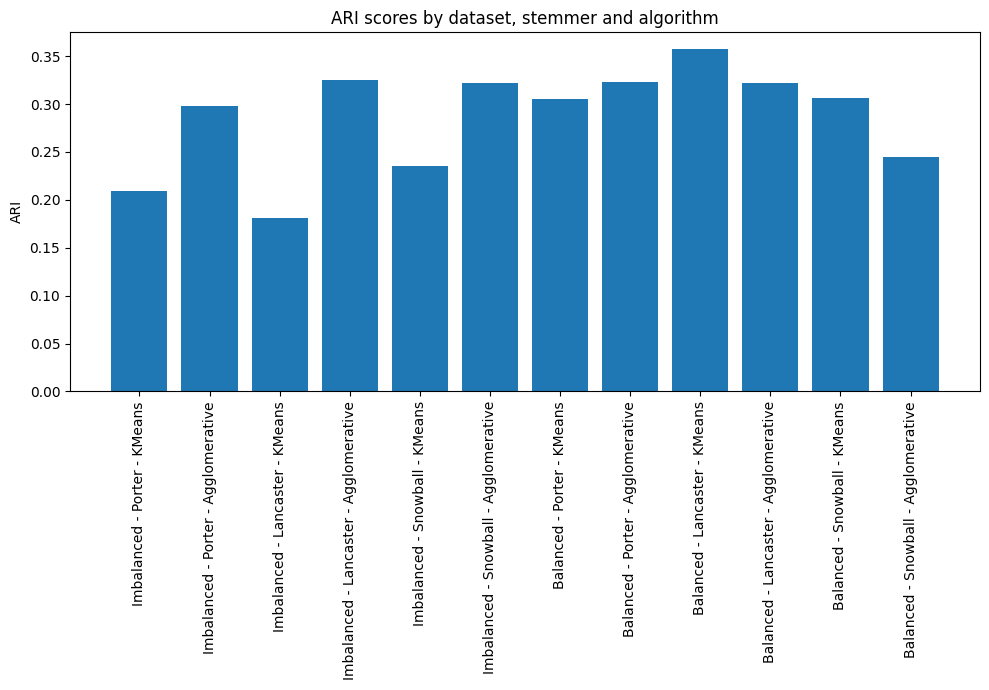

In [64]:
# Bar plot for ARI
plt.figure(figsize=(10, 7))
subset = results_df.dropna(subset=["ARI"])
x = np.arange(len(subset))
plt.bar(x, subset["ARI"])
plt.xticks(
    x,
    subset["Dataset"] + " - " + subset["Stemmer"] + " - " + subset["Algorithm"],
    rotation=90
)
plt.ylabel("ARI")
plt.title("ARI scores by dataset, stemmer and algorithm")
plt.tight_layout()
plt.show()

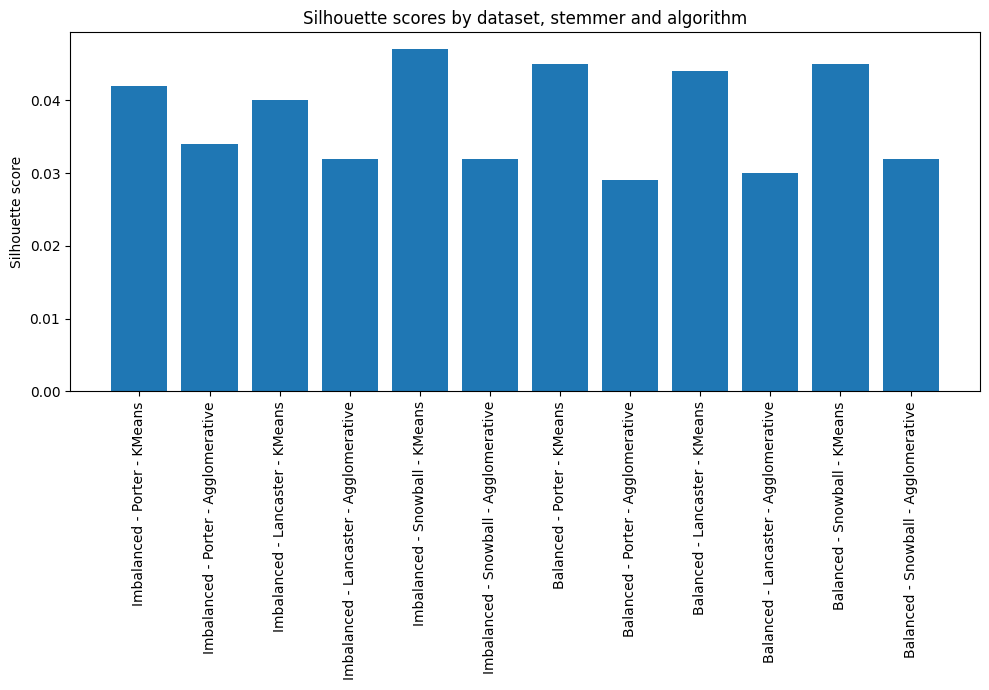

In [65]:
# Bar plot for Silhouette
plt.figure(figsize=(10, 7))
x = np.arange(len(results_df))
plt.bar(x, results_df["Silhouette"])
plt.xticks(
    x,
    results_df["Dataset"] + " - " + results_df["Stemmer"] + " - " + results_df["Algorithm"],
    rotation=90
)
plt.ylabel("Silhouette score")
plt.title("Silhouette scores by dataset, stemmer and algorithm")
plt.tight_layout()
plt.show()


This cell prints a clear summary of the best results.
You can use this text to help you write the Results and Discussion sections.

**From this you’ll be able to say things like:**

which stemmer + algorithm is best on imbalanced data

which is best on balanced data

how much ARI improves after balancing

whether Lancaster is really worse (aggressive stemming)

In [66]:
print("\nSorted by ARI (best at top):")
display(results_df.sort_values(by="ARI", ascending=False).head(10))

print("\nSorted by Silhouette (best at top):")
display(results_df.sort_values(by="Silhouette", ascending=False).head(10))



Sorted by ARI (best at top):


,Dataset,Stemmer,Algorithm,Best_k,Silhouette,DBI,ARI
8,Balanced,Lancaster,KMeans,10,0.044,4.815,0.357
3,Imbalanced,Lancaster,Agglomerative,8,0.032,4.961,0.325
7,Balanced,Porter,Agglomerative,10,0.029,4.152,0.323
9,Balanced,Lancaster,Agglomerative,10,0.030,4.378,0.322
5,Imbalanced,Snowball,Agglomerative,10,0.032,4.483,0.322
10,Balanced,Snowball,KMeans,10,0.045,4.598,0.306
6,Balanced,Porter,KMeans,10,0.045,4.579,0.305
1,Imbalanced,Porter,Agglomerative,10,0.034,4.586,0.298
11,Balanced,Snowball,Agglomerative,10,0.032,4.699,0.245
4,Imbalanced,Snowball,KMeans,10,0.047,4.190,0.235



Sorted by Silhouette (best at top):


,Dataset,Stemmer,Algorithm,Best_k,Silhouette,DBI,ARI
4,Imbalanced,Snowball,KMeans,10,0.047,4.190,0.235
6,Balanced,Porter,KMeans,10,0.045,4.579,0.305
10,Balanced,Snowball,KMeans,10,0.045,4.598,0.306
8,Balanced,Lancaster,KMeans,10,0.044,4.815,0.357
0,Imbalanced,Porter,KMeans,10,0.042,4.589,0.209
2,Imbalanced,Lancaster,KMeans,8,0.040,4.133,0.181
1,Imbalanced,Porter,Agglomerative,10,0.034,4.586,0.298
3,Imbalanced,Lancaster,Agglomerative,8,0.032,4.961,0.325
11,Balanced,Snowball,Agglomerative,10,0.032,4.699,0.245
5,Imbalanced,Snowball,Agglomerative,10,0.032,4.483,0.322
